# Progressive Fingerprint GAN


## Introduction

An open problem in the area of Latent Fingerprint Recognition is the enhancement of poor quality fingerprints for the purpose of improving fingerprint matching accuracy. Although there a lots of algorithms out there to enhance fingerprint images, the results of some of the best solutions are less than satisfactory. For this reason, my research was on the use of Generative Adversarial Networks for the purpose of enhacing images of latent fingerprints for improving matching accuracy.

This GAN was adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. It is similar to traditional GANs.

TBA

## Install Dependencies

In [1]:
!pip install Augmentor
!pip install pillow
!pip install seaborn
%reload_ext autoreload
%autoreload

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms.functional as Fv

import os
import time
import math
import random
import Augmentor
import numpy as np
import random
from numpy import unravel_index 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import Random
from skimage.util import random_noise

from IPython.display import HTML
import matplotlib.animation as animation

## Config

In [74]:
target_dir   = "../../storage/Prepped_Fingerprints_206x300/Bad/"
template_dir = "../../storage/Prepped_Fingerprints_206x300/Enhanced_Good/"

model_results_file = "checkpoint/GAN_results.pt"
model_ckpt_file = "checkpoint/GAN_checkpoint.pt"

im_size = (300, 206)
var_max = 0.5

num_train = 20000
num_valid = 1000
batch_size = 64
num_workers = 1
shuffle = True
augment = True

# Number of training epochs
num_epochs = 20
start_epoch = 1

# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

ssnnModelFilepath = "checkpoint/SSNN_results.pt"

## Utils

In [162]:
def loadSiameseNN(filepath, netS):
    # Load checkpoint
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        netS.load_state_dict(checkpoint['netS_state_dict'])
        #optimizerS.load_state_dict(checkpoint['optimizerS_state_dict'])
        #S_losses = checkpoint['S_losses']
        #iters = checkpoint['iters']
        #start_epoch = checkpoint['epoch']
    else:
        raise Exception("Could not Load Siamse NN. " + filepath + " not found")
    return netS #, optimizerS, S_losses, iters, start_epoch


def plotFigures(img_list):
    plt.figure(figsize=(15,15))
    plt.subplot(1,1,1)
    plt.axis("off")
    plt.title("GAN Enhanced Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    return img_list

    
def saveCkpt(filepath, epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list, test_batch, iters):
    if os.path.isfile(filepath):
        os.remove(filepath)
    torch.save({
        'epoch' : epoch,
        'netG_state_dict' : netG.state_dict(),
        'netD_state_dict' : netD.state_dict(),
        'optimizerG_state_dict' : optimizerG.state_dict(),
        'optimizerD_state_dict' : optimizerD.state_dict(),
        'G_losses' : G_losses,
        'D_losses' : D_losses,
        'img_list' : img_list,
        'test_batch' : test_batch,
        'iters' : iters,
    }, filepath)


def showImages(batch, labels=None):
    """
    Displays a set of batch images
    
    :param batch: A batch of image pairs and labels to display
    :praam labels: The labels for the images
    """
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()
    
    if labels is not None:
        for l in labels:
            if l == 1:
                print("  same  ", end=" ")
            else:
                print("  diff  ", end=" ")
        
        
def validate(epoch):
    # switch to evaluate mode
    netD.eval()

    correct = 0
    total = 0
    for i, (val_Im1, val_Im2, val_y) in enumerate(valid_loader):
        with torch.no_grad():
            variation = random.uniform(0,var_max)
            val_Im1 = torch.tensor(random_noise(val_Im1, mode='gaussian', mean=0, var=variation, clip=True), dtype=torch.float32)
            val_Im1, val_Im2, val_y = val_Im1.to(device), val_Im2.to(device), val_y.to(device)
            batch_size = val_Im1.shape[0]

            # compute log probabilities
            pred = torch.round(netD(val_Im1, val_Im2))
            correct += (pred == val_y).sum().item()
            total += batch_size
            if total > num_valid:
                break

        # compute acc and log
        valid_acc = (100. * correct) / total
        return valid_acc
    
                
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class MovingAvg(object):
    """
    Computes the moving average of values
    """
    def __init__(self, length=10):
        self.length = length
        self.movingAvg = np.array([], dtype='f')
        
    def average(self):
        return np.average(self.movingAvg)
        
    def pop(self):
        if len(self.movingAvg > 0):
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
    
    def push(self, val):
        self.movingAvg = np.append(self.movingAvg, [val])
        if len(self.movingAvg) > self.length:
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
            


## Data Loader

In [76]:
def get_train_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train 
    iterator over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:10000]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader)



def get_train_valid_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    iterators over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:7500]
    validation_prints = fingerprints[7500:]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # Get the Validation Dataloader 
    valid_dataset = FingerprintLoader(target_dir, template_dir, num_valid, validation_prints, batch_size)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader, valid_loader)
    

class FingerprintLoader(Dataset):
    """
    This class is used to help load the fingerpint dataset.
    """
    def __init__(self, target_dataset, template_dataset, num_train, dataset, batch_size):
        """
        Initializes an instance for the FingerprintLoader class.

        :param self: instance of the FingerprintLoader class
        :param template_dataset: The template fingerprint dataset
        :param target_dataset: The second fingerprint dataset to match against 
                               the template dataset
        :param num_train: The number of images to load
        :param dataset: List of fingerprints to include in the set
        """
        super(FingerprintLoader, self).__init__()
        self.target_dataset = target_dataset
        self.template_dataset = template_dataset
        self.fingerprints_dataset = dataset
        self.num_train = num_train
        self.augment = augment
        self.batch_size = batch_size
        self.batchInd = batch_size
        self.target_im_name = ""

    def __len__(self):
        """
        Helper function to return the length of the dataset

        :param self: instance of the FingerprintLoader class
        :return: the length of the dataset as an int
        """
        return self.num_train

    def __getitem__(self, index):
        """
        Getter function for accessing images from the dataset. This function will choose a 
        fingerprint image from the dataset and its corresponding enhanced fingerprint image.
        It will then preprocess the images before returning them.
        :param self: instance of the FingerprintLoader class
        :param index: index for data image in set to return
        :return: Image from dataset as a tensor
        """
        target_im_filepath, enhanced_target_im_filepath = self.chooseTargetAndTemplateImages()
        targ_im = self.preprocessImage(target_im_filepath)
        enhanced_targ_im = self.preprocessImage(enhanced_target_im_filepath)
        return targ_im, enhanced_targ_im
    
    
    def chooseTargetAndTemplateImages(self):
        """
        Returns the filepath of the target fingerprint image and the enhanced template fingerprint.
        :param self: instance of the FingerprintLoader class
        :return: The filepaths for the 
        """
        target_im_filepath = "targetim.jpg" 
        enhanced_target_im_filepath = "targetim.jpg"      
        # Chose image
        while not os.path.isfile(target_im_filepath) or not os.path.isfile(enhanced_target_im_filepath):
            target_im_filepath = self.target_dataset + random.choice(os.listdir(self.target_dataset))
            target_im_filepath +=  "/Impression_1/"
            if self.batchInd % self.batch_size == 0:
                self.target_im_name = random.choice(self.fingerprints_dataset)
            target_im_filepath = target_im_filepath + self.target_im_name + '.jpg'
            enhanced_target_im_filepath = self.template_dataset + random.choice(os.listdir(self.template_dataset)) \
                + "/Impression_1/" + self.target_im_name + '.jpg' 
        self.batchInd += 1
        return target_im_filepath, enhanced_target_im_filepath
    
    
    def preprocessImage(self, im_filepath):
        """
        Preprocesses the image. This function will open the image, convert 
        it to grayscale, pad the image in order to make is square, 
        normalize the image, and then finally convert it to a tensor.
        :param im: Filepath of the image to preprocess
        :return: The preprocessed image
        """
        im = Image.open(im_filepath)
        # Convert to Grayscale
        trans = transforms.Compose([#p.torch_transform(),
                                transforms.Resize(im_size),
                                #transforms.CenterCrop(im_size),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),
                              ])
        # Apply the transformations to the images and labels
        preprocessedImage = trans(im)
        return preprocessedImage

## Data Visualization for GAN
A dataset of over 800,000 synthetically generated fingerprints were used for training, which were generated by using [Anguli](https://dsl.cds.iisc.ac.in/projects/Anguli/). Different backgrounds were used in an attempt to make the GAN more general. 

Below are some sample images that the GAN will be trained on. The top row represents the input fingerprint images that the generator is to enhance. The bottom row are the enhanced versions of the fingerprints in the top row, which were enhanced using Gabor Filters (a common method for enhancing fignerprint images). Please note that the 
in the bottom row are not necessarly the fingerprints in the top row that where enhanced using Gabor Filters. They represent what the input fingerprints (top row) should be enhanced to. The enhanced fingerprints in the bottom row were produced by enhancing the good impressions of the fingerprints shown in the top row.

The task of the generator is to enhance the images in the top row to look like Gabor Enhanced fingerprint images in the bottom row while also preserving the underlying ridge structure.

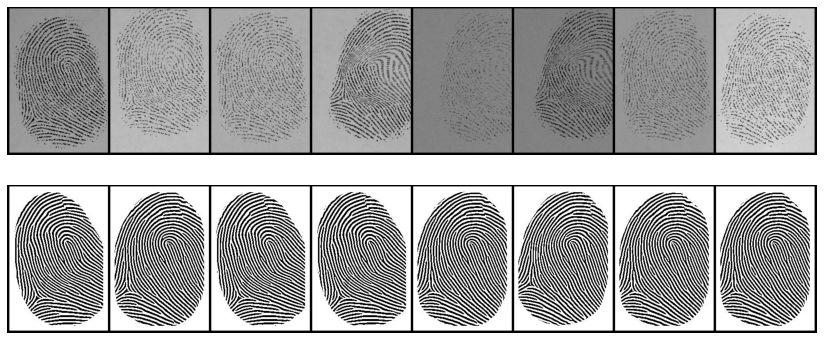

In [77]:
# Create the dataloader
#disp_dataset = dset.ImageFolder(root=data_dir)
disp_fingerprints = [str(finger) for finger in range(1,1000+1)]
disp_dataset = FingerprintLoader(target_dir, template_dir, num_train, disp_fingerprints, batch_size)
disp_dataloader = torch.utils.data.DataLoader(disp_dataset, batch_size=10,
                                         shuffle=shuffle, num_workers=1)

# Get a Batch of Sample Images
real_batch = next(iter(disp_dataloader))
batch = real_batch

# Display the Sample Images
plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(2,1,2)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()


In [78]:
# Size of Latent vector
aBatch = batch[1]
print(aBatch.shape)
print(aBatch.view(aBatch.size(0), -1, 1, 1).shape)
nz = aBatch.view(aBatch.size(0), -1, 1, 1).shape[1]
print(nz)

torch.Size([10, 1, 300, 206])
torch.Size([10, 61800, 1, 1])
61800


## Weight Initialization

In [79]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Siamese Neural Network

In [80]:
class SiameseNet(nn.Module):
    """
    A Convolutional Siamese Network for One-Shot Learning [1].
    Siamese networts learn image representations via a supervised metric-based
    approach. Once tuned, their learned features can be leveraged for one-shot
    learning without any retraining.
    References
    ----------
    https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py
    - Koch et al., https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
    """
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)
        # Batch Norm Layers
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(1225, 512)
        self.fc2 = nn.Linear(805, 1)

    def sub_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.
        Args
        ----
        - x: Contains either the first or second image pair across the input batch.
        Returns
        -------
        - out: The hidden vector representation of the input vector x.
        """
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        return out

    def forward(self, x1):
        """
        Forward pass the input image pairs through both subtwins. An image
        pair is composed of a left tensor x1 and a right tensor x2.
        Concretely, we compute the component-wise L1 distance of the hidden
        representations generated by each subnetwork, and feed the difference
        to a final fc-layer followed by a sigmoid activation function to
        generate a similarity score in the range [0, 1] for both embeddings.
        Args
        ----
        - x1: a Variable of size (B, C, H, W). The left image pairs along the
          batch dimension.
        - x2: a Variable of size (B, C, H, W). The right image pairs along the
          batch dimension.
        Returns
        -------
        - probas: a Variable of size (B, 1). A probability scalar indicating
          whether the left and right input pairs, along the batch dimension,
          correspond to the same class. We expect the network to spit out
          values near 1 when they belong to the same class, and 0 otherwise.
        """
        # encode image pairs
        h1 = self.sub_forward(x1)
        #h2 = self.sub_forward(x2)

        # compute l1 distance
        #diff = torch.abs(h1 - h2)
        
        # score the similarity between the 2 encodings
        #scores = torch.sigmoid(self.fc2(diff))

        return h1

In [81]:
# Create the Siamese Neural Network
netS = SiameseNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netS.apply(weights_init)

# Print the model
print(netS)


SiameseNet(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1225, out_features=512, bias=True)
  (fc2): Linear(in_features=805, out_features=1, bias=True)
)


In [82]:
# Load Siamese Neural Network
netS = loadSiameseNN(ssnnModelFilepath, netS)

In [145]:
# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader

# Create batch of latent vectors that we will use to visualize the progression of the generator
test_loader = get_train_loader(target_dir, template_dir, 8, num_train, num_valid, shuffle, **kwargs)
batch = next(iter(test_loader))

In [146]:
netS.eval()
output = netS(batch[0].to(device)[:8])

print(output.shape)

torch.Size([8, 805])


## Generator

In [169]:
# Generator Code
class Generator_1(nn.Module):
    def __init__(self, ngpu):
        super(Generator_1, self).__init__()
        # Device
        self.ngpu = ngpu

        self.deconv1 = nn.ConvTranspose2d(805, ngf * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)       
        self.deconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.deconv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.deconv4 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.deconv5 = nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)


    def forward(self, x):
        x = x.view(x.size(0), -1, 1, 1)
        # Layer 1: input is Z, going into a convolution
        out = F.relu(self.bn1(self.deconv1(x)), True)
        # Layer 2: state size. (ngf*8) x 4 x 4
        out = F.relu(self.bn2(self.deconv2(out)), True)
        # Layer 3: state size. (ngf*4) x 8 x 8
        out = F.relu(self.bn3(self.deconv3(out)), True)
        # Layer 4: state size. (ngf*2) x 16 x 16
        out = F.relu(self.bn4(self.deconv4(out)), True)
        # Layer 5: state size. (ngf) x 32 x 32
        out = torch.tanh(self.deconv5(out))
        # state size. (nc) x 64 x 64
        return out

In [189]:
# Create the generator
netG_1 = Generator_1(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG_1 = nn.DataParallel(netG_1, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG_1.apply(weights_init)

# Print the model
print(netG_1)

Generator_1(
  (deconv1): ConvTranspose2d(805, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


## Discriminator

In [190]:
class Discriminator_1(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_1, self).__init__()
        # Device
        self.ngpu = ngpu
        
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        nn.LeakyReLU(0.2, inplace=True)
        
        # state size. (ndf) x 32 x 32
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        
        # state size. (ndf*2) x 16 x 16
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        
        # state size. (ndf*4) x 8 x 8
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        
        # state size. (ndf*8) x 4 x 4
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

        # Fully Connected Layers
        self.fc1 = nn.Linear(135, 1)


    def forward(self, x):
        # Input 64 x 64
        out = F.leaky_relu_(self.conv1(x), 0.2)
        # state size. (ndf) x 32 x 32
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        # state size. (ndf*2) x 16 x 16
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        # state size. (ndf*4) x 8 x 8
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)   
        # state size. (ndf*8) x 4 x 4
        out = F.leaky_relu_(self.conv5(out), 0.2).view(x.shape[0], -1)
        #print(out.shape)
        #out = self.fc1(out)
        return torch.sigmoid(out)

In [191]:
# Create the Discriminator
netD_1 = Discriminator_1(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD_1 = nn.DataParallel(netD_1, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD_1.apply(weights_init)

# Print the model
print(netD_1)

Discriminator_1(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=135, out_features=1, bias=True)
)


## GAN Training

In [192]:
# Train
def train(netD, netG):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []

    iters = 0
    # switch to train mode
    netG.train()
    netD.train()

    print("\n[*] Train on {} sample pairs".format(
        num_train, num_valid)
    )

    gLossMvAvg = MovingAvg()

    for epoch in range(1, num_epochs+1):
        print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
        train_batch_time = AverageMeter()
        train_losses = AverageMeter()
        tic = time.time()
        with tqdm(total=num_train) as pbar:
            for i, (x1, enhanced_x1) in enumerate(train_loader): 
                x1, enhanced_x1 = x1.to(device), enhanced_x1.to(device)

                ############################
                # Update D network
                ###########################
                ## Train with all-Gabor Enhanced batch
                netD.zero_grad()
                # Format batch
                b_size = enhanced_x1.size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                # Forward pass real batch through D
                out = F.interpolate(enhanced_x1, size=(64, 64), mode='bicubic', align_corners=False)
                output = netD(out)
                output = output.view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-GAN_Enhanced batch
                z = netS(x1)
                
                GAN_Enhanced = netG(z)
                label.fill_(fake_label)
                # Classify all GAN_Enhanced batch with D
                output = netD(GAN_Enhanced.detach()).view(-1)
                # Calculate D's loss on the all-GAN_Enhanced batch
                errD_GAN_Enhanced = criterion(output, label)
                # Calculate the gradients for this batch
                errD_GAN_Enhanced.backward()
                D_G_z1 = output.mean().item()
                # Add the gradients from the all-real and all-GAN_Enhanced batches
                errD = errD_real + errD_GAN_Enhanced
                # Update D
                optimizerD.step()


                ############################
                # Update G network
                ############################
                netG.zero_grad()
                label.fill_(real_label)  # GAN_Enhanced labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-GAN_Enhanced batch through D
                output = netD(GAN_Enhanced).view(-1)
                # Calculate G's loss based on this output
                errG_quality = criterion(output, label)
                # Calculate gradients for G
                errG_quality.backward()
                D_G_z2 = output.mean().item()

                # Add the gradients
                errG = errG_quality 

                # Update G
                optimizerG.step()

                # store batch statistics
                toc = time.time()
                train_batch_time.update(toc-tic)
                tic = time.time()
                pbar.set_description(
                    (
                        "loss_D: {:.12f}  loss_G: {:.6f}".format(
                            errD.item(), errG.item()
                        )
                    )
                )
                pbar.update(batch_size)

                gLossMvAvg.push(errG.item())

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 10000 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        zt = netS(test_batch[0])
                        fake = netG(zt).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                    #saveCkpt(model_ckpt_file, epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list, test_batch, iters)

                iters += 1   
            # Plot the fake images from the last epoch
            #saveCkpt(model_ckpt_file, epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list, test_batch, iters)
            with torch.no_grad():
                zt = netS(test_batch[0])
                fake_disp = netG(zt).detach().cpu()
                img_list.append(vutils.make_grid(fake_disp, padding=2, normalize=True))
            plotFigures(img_list)
    return netD, netG, img_list, G_losses, D_losses 

## Set Training Params

In [193]:
# Init retrieval suction number one

# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader

# Create batch of latent vectors that we will use to visualize the progression of the generator
test_loader = get_train_loader(target_dir, template_dir, 8, num_train, num_valid, shuffle, **kwargs)
test_batch = []
test = next(iter(test_loader))
test_batch.append(test[0].to(device))     
test_batch.append(test[1].to(device))

criterion = nn.BCELoss()

# Learning rate for optimizers
dlr = 0.002
glr = 0.002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for both G, D, and S
optimizerD = optim.Adam(netD_1.parameters(), lr=dlr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG_1.parameters(), lr=glr, betas=(beta1, 0.999))

num_epochs = 10



[*] Train on 20000 sample pairs

Epoch: 1/10


loss_D: 1.756750226021  loss_G: 4.425691: 100%|█████████▉| 19968/20000 [01:15<00:00, 115.04it/s]

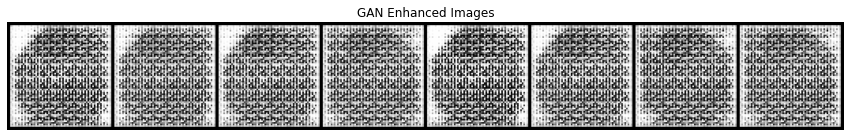

loss_D: 1.756750226021  loss_G: 4.425691: : 20032it [01:15, 265.63it/s]                         



Epoch: 2/10


loss_D: 1.450176119804  loss_G: 1.524127: : 20032it [01:11, 313.71it/s]                         

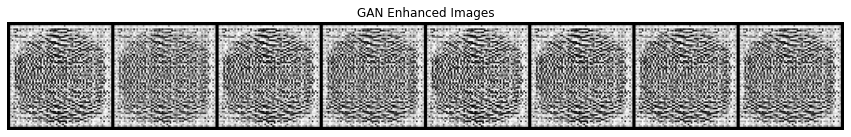

loss_D: 1.450176119804  loss_G: 1.524127: : 20032it [01:11, 279.40it/s]



Epoch: 3/10


loss_D: 1.513222932816  loss_G: 1.148194: 100%|█████████▉| 19968/20000 [01:09<00:00, 299.60it/s]

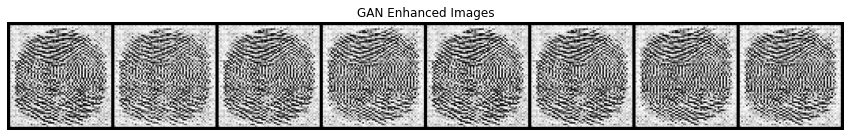

loss_D: 1.513222932816  loss_G: 1.148194: : 20032it [01:09, 286.68it/s]                         



Epoch: 4/10


loss_D: 1.945850491524  loss_G: 2.222612: 100%|█████████▉| 19968/20000 [01:10<00:00, 312.88it/s]

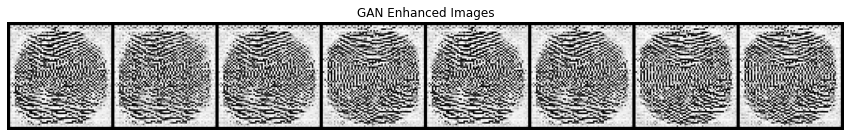

loss_D: 1.945850491524  loss_G: 2.222612: : 20032it [01:10, 284.66it/s]                         



Epoch: 5/10


loss_D: 0.602170348167  loss_G: 0.972557: : 20032it [01:11, 305.81it/s]                         

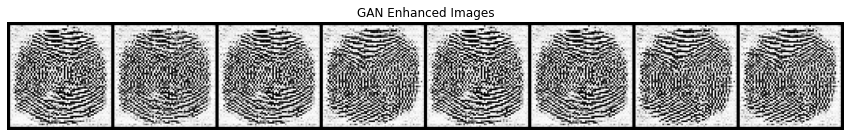

loss_D: 0.602170348167  loss_G: 0.972557: : 20032it [01:11, 280.22it/s]



Epoch: 6/10


loss_D: 1.345273494720  loss_G: 1.296683: 100%|█████████▉| 19968/20000 [01:13<00:00, 303.34it/s]

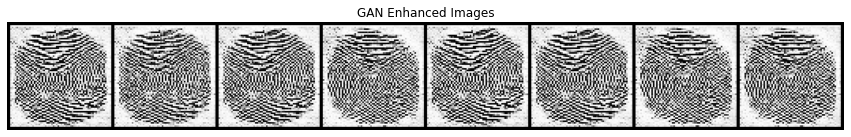

loss_D: 1.345273494720  loss_G: 1.296683: : 20032it [01:13, 272.27it/s]                         



Epoch: 7/10


loss_D: 1.185639858246  loss_G: 0.787695: : 20032it [01:10, 372.90it/s]                         

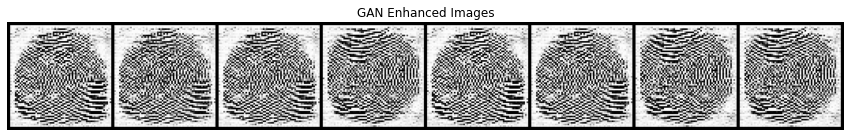

loss_D: 1.185639858246  loss_G: 0.787695: : 20032it [01:10, 283.73it/s]



Epoch: 8/10


loss_D: 1.435064315796  loss_G: 2.051480: : 20032it [01:08, 341.35it/s]                         

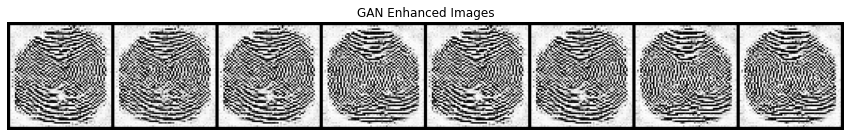

loss_D: 1.435064315796  loss_G: 2.051480: : 20032it [01:08, 291.56it/s]



Epoch: 9/10


loss_D: 0.628077447414  loss_G: 1.107777: : 20032it [01:13, 316.86it/s]                         

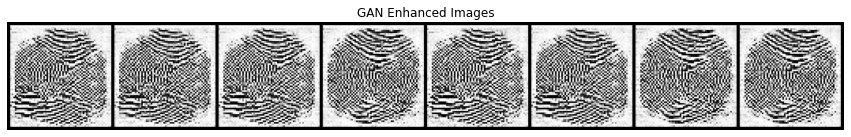

loss_D: 0.628077447414  loss_G: 1.107777: : 20032it [01:13, 271.69it/s]



Epoch: 10/10


loss_D: 1.401056051254  loss_G: 1.140424: 100%|█████████▉| 19968/20000 [01:11<00:00, 323.14it/s]

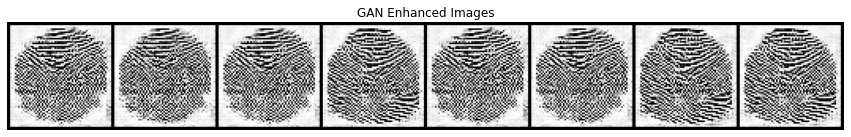

loss_D: 1.401056051254  loss_G: 1.140424: : 20032it [01:12, 277.82it/s]                         


In [194]:
# Firing Number One
netD, netG, img_list, G_losses, D_losses = train(netD_1, netG_1)

In [ ]:
# Init retrieval suction number two

im_size = (8, 8)
netD_1.fc1 = nn.Linear(256, 1).to(device)

# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader

# Create batch of latent vectors that we will use to visualize the progression of the generator
test_loader = get_train_loader(target_dir, template_dir, 8, num_train, num_valid, shuffle, **kwargs)
test_batch = []
test = next(iter(test_loader))
test_batch.append(test[0].to(device))     
test_batch.append(test[1].to(device))

criterion = nn.BCELoss()

# Learning rate for optimizers
dlr = 0.002
glr = 0.002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for both G, D, and S
optimizerD = optim.Adam(netD_1.parameters(), lr=dlr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG_1.parameters(), lr=glr, betas=(beta1, 0.999))

num_epochs = 4



[*] Train on 20000 sample pairs

Epoch: 1/4


loss_D: 1.379199266434  loss_G: 0.683313: 100%|█████████▉| 19968/20000 [00:56<00:00, 362.00it/s]

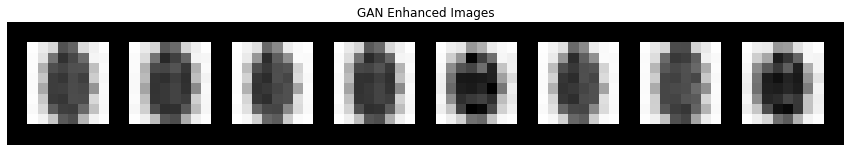

loss_D: 1.379199266434  loss_G: 0.683313: : 20096it [00:56, 352.75it/s]                         



Epoch: 2/4


loss_D: 1.353893876076  loss_G: 0.701341: : 20096it [01:01, 489.63it/s]                         

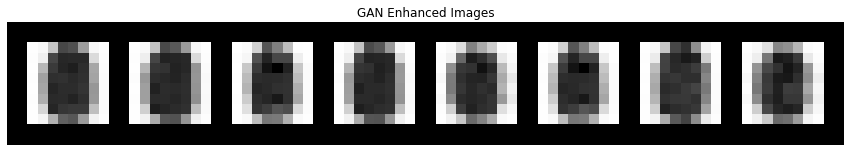

loss_D: 1.353893876076  loss_G: 0.701341: : 20096it [01:01, 328.39it/s]



Epoch: 3/4


loss_D: 1.358705401421  loss_G: 0.715903: : 20096it [00:55, 434.12it/s]                         

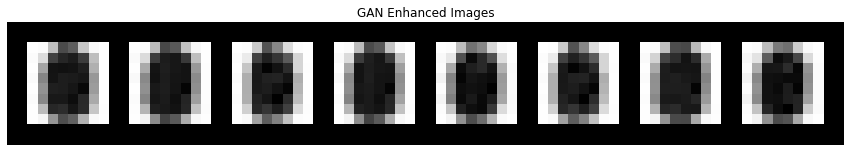

loss_D: 1.358705401421  loss_G: 0.715903: : 20096it [00:56, 358.85it/s]



Epoch: 4/4


loss_D: 1.347987532616  loss_G: 0.713047: : 20096it [00:56, 458.32it/s]                         

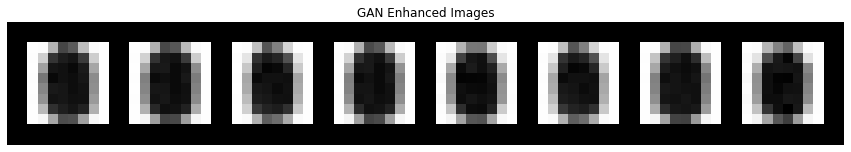

loss_D: 1.347987532616  loss_G: 0.713047: : 20096it [00:56, 355.71it/s]


In [177]:
# Firing Number Two
netD, netG, img_list, G_losses, D_losses = train(netD_1, netG_1)

In [178]:
# Init retrieval suction number three

im_size = (16, 16)
netD_1.fc1 = nn.Linear(1024, 1).to(device)

# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader

# Create batch of latent vectors that we will use to visualize the progression of the generator
test_loader = get_train_loader(target_dir, template_dir, 8, num_train, num_valid, shuffle, **kwargs)
test_batch = []
test = next(iter(test_loader))
test_batch.append(test[0].to(device))     
test_batch.append(test[1].to(device))

criterion = nn.BCELoss()

# Learning rate for optimizers
dlr = 0.002
glr = 0.002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for both G, D, and S
optimizerD = optim.Adam(netD_1.parameters(), lr=dlr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG_1.parameters(), lr=glr, betas=(beta1, 0.999))

num_epochs = 4



[*] Train on 20000 sample pairs

Epoch: 1/4


loss_D: 0.128553181887  loss_G: 2.201369: : 20096it [01:02, 468.33it/s]                         

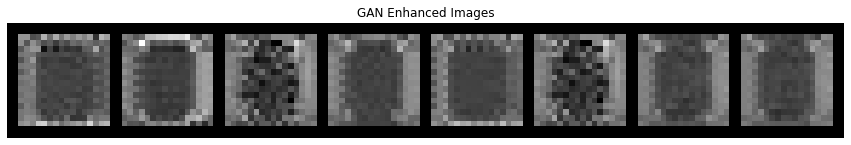

loss_D: 0.128553181887  loss_G: 2.201369: : 20096it [01:03, 318.54it/s]



Epoch: 2/4


loss_D: 0.110928572714  loss_G: 2.352978: : 20096it [00:59, 470.14it/s]                         

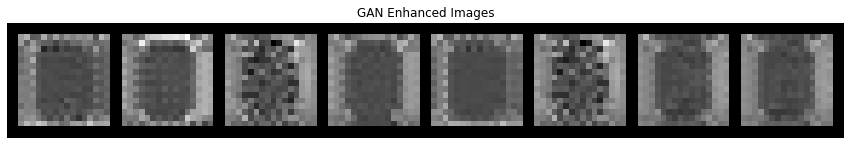

loss_D: 0.110928572714  loss_G: 2.352978: : 20096it [00:59, 337.40it/s]



Epoch: 3/4


loss_D: 0.097164943814  loss_G: 2.474596: : 20096it [00:57, 428.98it/s]                         

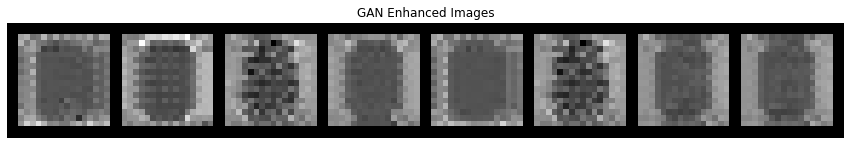

loss_D: 0.097164943814  loss_G: 2.474596: : 20096it [00:57, 349.90it/s]



Epoch: 4/4


loss_D: 0.109488829970  loss_G: 2.515340: : 20096it [01:04, 423.19it/s]                         

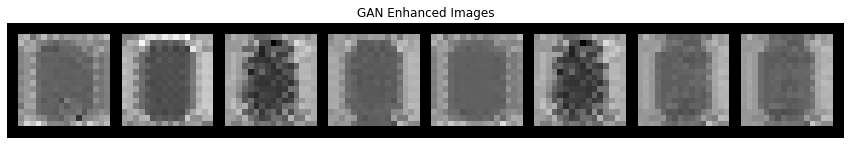

loss_D: 0.109488829970  loss_G: 2.515340: : 20096it [01:04, 312.80it/s]


In [180]:
# Number Three
netD, netG, img_list, G_losses, D_losses = train(netD_1, netG_1)

## Results

### Training Loss

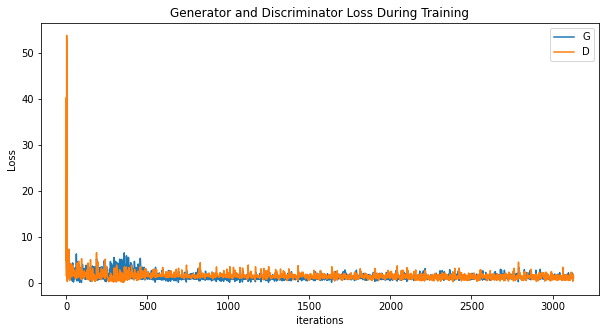

In [195]:
def displayTrainingLoss(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
displayTrainingLoss(G_losses, D_losses)

## Animation of Generator Progression.

Below is an animation of the generator's progression throughout training. Note, for each frame, the generator was fed the same batch of sample images as input.

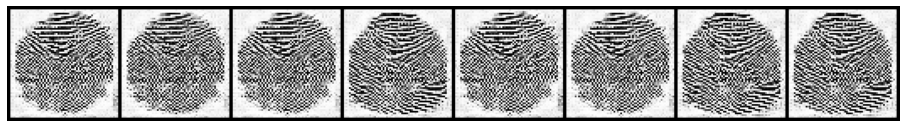

In [196]:
#%%capture
fig = plt.figure(figsize=(16,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Side by Side Comparison of GAN Enhanced and Ideal Gabor Enhanced Fingerprint Images
* Top: Original Input Fingerprint Impressions
* Middle: GAN Enhanced Images
* Bottom: Ideal Gabor Enhanced Images

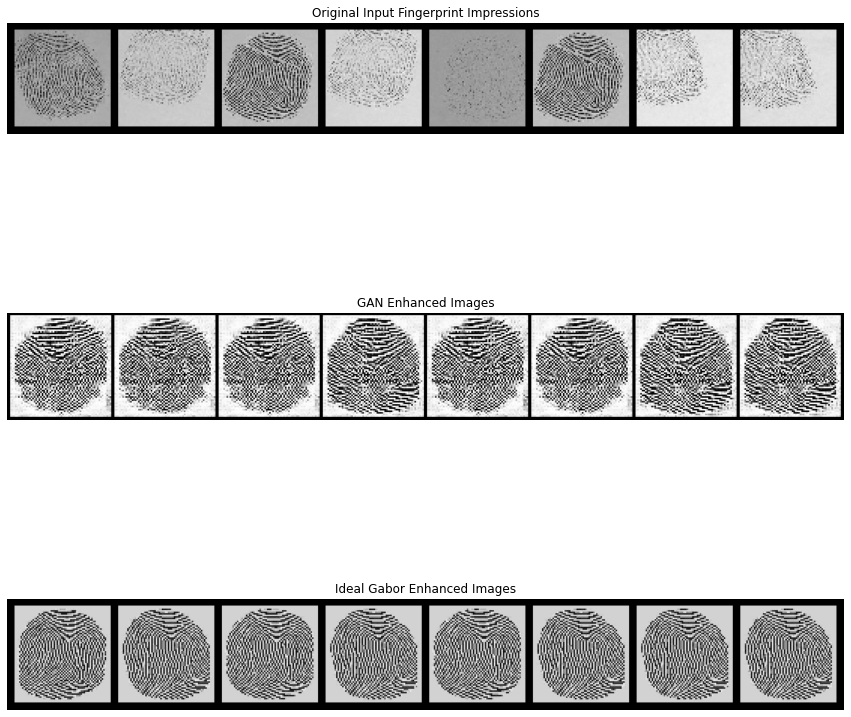

In [197]:
def displayComparision(test_batch, img_list):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(test_loader))

    # Plot the noisy images
    original = out = F.interpolate(test_batch[0].to(device)[:], size=(64, 64), mode='bicubic', align_corners=False)
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    plt.axis("off")
    plt.title("Original Input Fingerprint Impressions")
    #plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.imshow(np.transpose(vutils.make_grid(original, padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(3,1,2)
    plt.axis("off")
    plt.title("GAN Enhanced Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))

    # Plot the real images
    real = out = F.interpolate(test_batch[1].to(device)[:], size=(64, 64), mode='bicubic', align_corners=False)
    plt.subplot(3,1,3)
    plt.axis("off")
    plt.title("Ideal Gabor Enhanced Images")
    #plt.imshow(np.transpose(vutils.make_grid(test_batch[1].to(device)[:], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.imshow(np.transpose(vutils.make_grid(real, padding=5, normalize=True).cpu(),(1,2,0)))

    plt.show()
    
displayComparision(test_batch, img_list)

In [156]:
im_size = (16, 16)

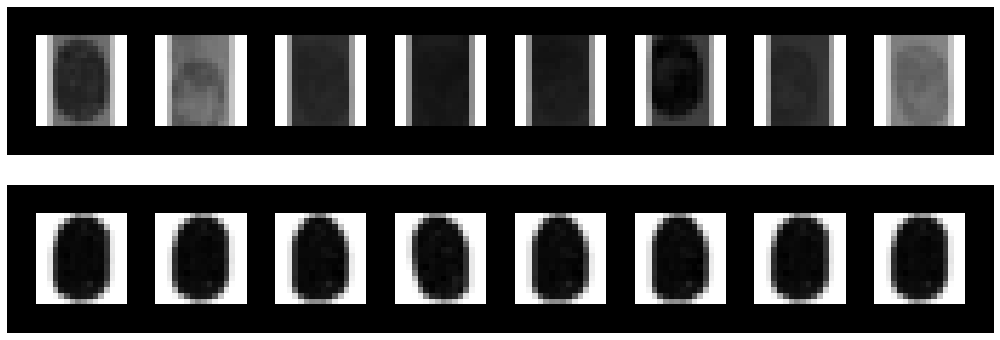

In [157]:
# Create the dataloader
#disp_dataset = dset.ImageFolder(root=data_dir)
disp_fingerprints = [str(finger) for finger in range(1,1000+1)]
disp_dataset = FingerprintLoader(target_dir, template_dir, num_train, disp_fingerprints, batch_size)
disp_dataloader = torch.utils.data.DataLoader(disp_dataset, batch_size=10,
                                         shuffle=shuffle, num_workers=1)

# Get a Batch of Sample Images
real_batch = next(iter(disp_dataloader))
batch = real_batch

# Display the Sample Images
plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(2,1,2)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()


In [158]:
# Generator Code
class Generator_2(nn.Module):
    def __init__(self, ngpu):
        super(Generator_2, self).__init__()
        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        # Takes 16 x 16 images with 1 channel. Converts to 8 x 8 image with 256 channels
        self.conv1 = nn.Conv2d(nc, ngf * 4, 4, 2, 1, bias=False)
        # Takes 8 x 8 image with 256 channels. Converts to 4 x 4 image with 512 channels
        self.conv4 = nn.Conv2d(ngf * 4, ngf * 8, 4, 2, 1, bias=False)
        # Takes 4 x 4 image with 512 channels. Converts to 2 x 2 image with 1024 channels
        self.conv5 = nn.Conv2d(ngf * 8, ngf * 16, 4, 2, 1, bias=False)
        # Transpose Convolutional Layers
        # Takes 2 x 2 image with 1024 channels. Converts to 4 x 4 image with 512 channels
        self.deconv5 = nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False)
        # Takes 4 x 4 image with 512 channels. Converts to 8 x 8 image with 1 channel
        self.deconv4 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        # Takes 8 x 8 image with 256 channels. Converts to 16 x 16 image with 1 channel
        self.deconv1 = nn.ConvTranspose2d(ngf * 4, nc, 4, 2, 1, bias=False)
        # Batch Normalization Layers
        self.bn0 = nn.BatchNorm2d(ngf)
        self.bn1 = nn.BatchNorm2d(ngf * 2)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.bn3 = nn.BatchNorm2d(ngf * 8)
        self.bn4 = nn.BatchNorm2d(ngf * 16)


    def forward(self, x):
        out = F.relu(self.conv1(x), True)
        out = F.relu(self.bn3(self.conv4(out)), True)
        out = F.relu(self.bn4(self.conv5(out)), True)
        out = F.relu(self.bn3(self.deconv5(out)), True)
        out = F.relu(self.bn2(self.deconv4(out)), True)
        out = torch.tanh(self.deconv1(out))
        return out

In [159]:
# Create the generator
netG_2 = Generator_2(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG_2 = nn.DataParallel(netG_2, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG_2.apply(weights_init)

# Transfer learning
netG_2.conv5 = netG_1.conv5
netG_2.deconv5 = netG_1.deconv5


# Print the model
print(netG_2)

Generator_2(
  (conv1): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv5): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv1): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1,

In [167]:
class Discriminator_2(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_2, self).__init__()
        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf * 8, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 16, 1, 4, 2, 1, bias=False)
        # Batch Norm Layers
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(4, 1)


    def forward(self, x):
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.conv4(out), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        #print(out.shape)
        out = self.fc1(out)
        return torch.sigmoid(out)

In [173]:
# Create the Discriminator
netD_2 = Discriminator_2(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD_2 = nn.DataParallel(netD_2, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD_2.apply(weights_init)

# Transfer learning
#netD_2.conv5 = netD_1.conv5

# Print the model
print(netD_2)

Discriminator_2(
  (conv1): Conv2d(1, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4, out_features=1, bias=True)
)


In [174]:
# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader

# Create batch of latent vectors that we will use to visualize the progression of the generator
test_loader = get_train_loader(target_dir, template_dir, 8, num_train, num_valid, shuffle, **kwargs)
test_batch = []
test = next(iter(test_loader))
test_batch.append(test[0].to(device))     
test_batch.append(test[1].to(device))

criterion = nn.BCELoss()

# Learning rate for optimizers
dlr = 0.0002
glr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for both G, D, and S
optimizerD = optim.Adam(netD_2.parameters(), lr=dlr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG_2.parameters(), lr=glr, betas=(beta1, 0.999))



[*] Train on 20000 sample pairs

Epoch: 1/2


loss_D: 1.081781506538  loss_G: 1.344908: : 20096it [01:05, 398.23it/s]                         

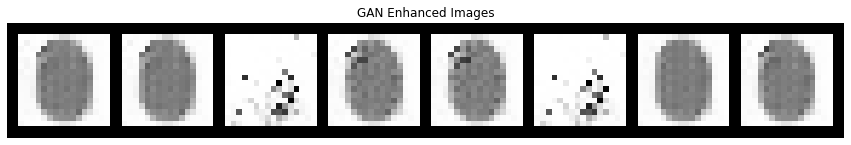

loss_D: 1.081781506538  loss_G: 1.344908: : 20096it [01:05, 306.95it/s]



Epoch: 2/2


loss_D: 1.333898305893  loss_G: 0.771083: : 20096it [00:59, 405.60it/s]                         

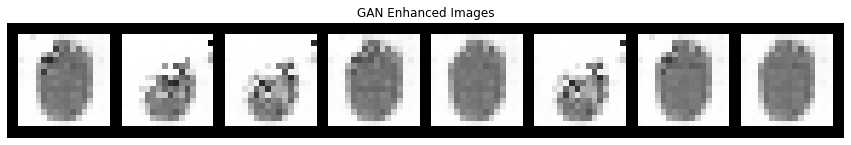

loss_D: 1.333898305893  loss_G: 0.771083: : 20096it [00:59, 339.61it/s]


In [175]:
# Train the Network
netD, netG, img_list, G_losses, D_losses = train(netD_2, netG_2)